In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from a4_utils import *

def simple_convolution(signal, kernel):
    N = int(len(kernel) / 2) # kernel of size 2N + 1
    returnSignal = np.zeros(len(signal))
    for i in range(0, len(signal)): # loop through signal
        for j in range(0, 2*N+1): # loop through kenel
            index = i-(j-N)
            if index < 0: # extending edge
                index = 0
            elif index > len(signal)-1:
                index = len(signal)-1
            returnSignal[i] += kernel[j]*signal[index] # weigted sum

    return returnSignal

    
def gauss(sigma):
    N = int(np.ceil(3 * sigma))
    kernel = np.zeros(2 * N + 1)
    for x in range(-N, N):
        kernel[x+N] = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-x**2 / (2 * (sigma**2)))

    return kernel / np.sum(kernel)

def gaussdx(sigma):
    N = int(np.ceil(3 * sigma))
    kernel = np.zeros(2 * N + 1)
    sumOfAbs = 0
    for x in range(-N, N):
        v = -1 / (np.sqrt(2 * np.pi) * sigma**3) * x * np.exp(-x**2 / (2 * (sigma**2)))
        kernel[x+N] = v
        sumOfAbs += np.abs(v)

    return kernel / sumOfAbs

def partialDerivative(img, sigma):
    gaussKenrnel = gauss(sigma)
    dxGaussKernel = gaussdx(sigma)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, gaussKenrnel)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, dxGaussKernel)
    return img

def getDerivatives(img, sigma):
    Ix = partialDerivative(np.copy(img), sigma)
    Iy = partialDerivative(np.copy(img.T), sigma).T
    Ixx = partialDerivative(np.copy(Ix), sigma)
    Iyy = partialDerivative(np.copy(Iy.T), sigma).T
    Ixy = partialDerivative(np.copy(Ix.T), sigma).T
    return Ix,Iy,Ixx,Iyy,Ixy

def gradient_magnitude(img):
    Ix, Iy, Ixx, Iyy, Ixy = getDerivatives(img, 1)
    magnitude = np.sqrt(Ix ** 2 + Iy ** 2)
    angle = np.arctan2(Ix,Iy)
    return magnitude, angle

def non_maxima_suppression(det, hw):
    arr = np.copy(det)
    for y, row in enumerate(arr):
        for x, pixel in enumerate(row):
            if x < hw or y < hw or x >= len(row) - hw or y >= len(arr) - hw:
                arr[y, x] = 0
                continue
            if(det[y,x] < np.max(det[(y-hw):(y+hw+1),(x-hw):(x+hw+1)])):
                arr[y,x] = 0
    return arr

def hessian_points(Ixx, Iyy, Ixy, threshold):
    det = Ixx * Iyy - Ixy * Ixy
    nnmsDet = non_maxima_suppression(det, 8)
    nnmsDet[nnmsDet <= threshold] = 0.0
    return det, nnmsDet

def gaussFilter(img, sigma):
    gaussKenrnel = gauss(sigma)
    img = np.copy(img.T)
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, gaussKenrnel)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, gaussKenrnel)
    return img

def auto_correlation_matrix(Ix, Iy, sigma):
    C11 = gaussFilter(Ix*Ix, sigma)
    C12 = gaussFilter(Ix*Iy, sigma)
    C21 = C12
    C22 = gaussFilter(Iy*Iy, sigma)
    return C11, C12, C21, C22

def herris_points(C11, C12, C21, C22, alpha, threshold):
    detC = C11*C22-C12*C21
    traceC = C11+C22
    arr = detC-alpha*traceC*traceC
    arr[arr <= threshold] = 0
    nnmsArr = non_maxima_suppression(arr, 10)
    return arr, nnmsArr

In [3]:
# temp = cv2.imread('data/graf/graf_a.jpg') # 0-255
# temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
# temp = temp.astype(np.float64) / 255

# Ix3, Iy3, Ixx3, Iyy3, Ixy3 = getDerivatives(temp, 3)
# Ix6, Iy6, Ixx6, Iyy6, Ixy6 = getDerivatives(temp, 6)
# Ix9, Iy9, Ixx9, Iyy9, Ixy9 = getDerivatives(temp, 9)
# det3, nnmsDet3 = hessian_points(Ixx3, Iyy3, Ixy3, 0.004)
# det6, nnmsDet6 = hessian_points(Ixx6, Iyy6, Ixy6, 0.004)
# det9, nnmsDet9 = hessian_points(Ixx9, Iyy9, Ixy9, 0.004)
# points = np.nonzero(nnmsDet3)
# points2 = np.nonzero(nnmsDet6)
# points3 = np.nonzero(nnmsDet9)

# C311, C312, C321, C322 = auto_correlation_matrix(Ix3, Iy3, 1.6 * 3)
# C611, C612, C621, C622 = auto_correlation_matrix(Ix6, Iy6, 1.6 * 6)
# C911, C912, C921, C922 = auto_correlation_matrix(Ix9, Iy9, 1.6 * 9)
# h3, nnmsH3 = herris_points(C311, C312, C321, C322, 0.06, 10**(-6))
# h6, nnmsH6 = herris_points(C611, C612, C621, C622, 0.06, 10**(-6))
# h9, nnmsH9 = herris_points(C911, C912, C921, C922, 0.06, 10**(-6))
# points = np.nonzero(nnmsH3)
# points2 = np.nonzero(nnmsH6)
# points3 = np.nonzero(nnmsH9)

# Exercise 2
### a

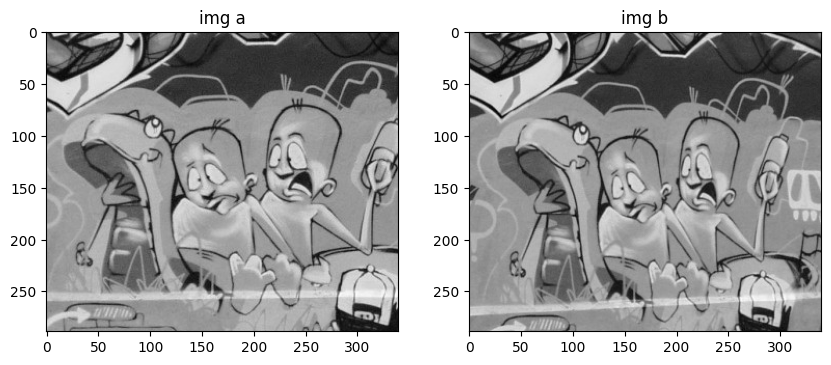

In [4]:
temp = cv2.imread('data/graf/graf_a_small.jpg') # 0-255
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
temp = temp.astype(np.float64) / 255
temp2 = cv2.imread('data/graf/graf_b_small.jpg') # 0-255
temp2 = cv2.cvtColor(temp2, cv2.COLOR_BGR2GRAY)
temp2 = temp2.astype(np.float64) / 255

f = plt.figure(figsize=(10, 10))
f.add_subplot(1, 2, 1)
plt.imshow(temp, cmap="gray")
plt.title("img a")
f.add_subplot(1, 2, 2)
plt.imshow(temp2, cmap="gray")
plt.title("img b")
plt.show()

In [ ]:
# temp = temp[0:100,0:100]
# temp2 = temp2[0:100,0:100]
Ix, Iy, Ixx, Iyy, Ixy = getDerivatives(temp, 3)
Ix2, Iy2, Ixx2, Iyy2, Ixy2 = getDerivatives(temp2, 3)

In [66]:
det, nnmsDet = hessian_points(Ixx, Iyy, Ixy, 0.002)
det2, nnmsDet2 = hessian_points(Ixx2, Iyy2, Ixy2, 0.002)
points = np.nonzero(nnmsDet)
points2 = np.nonzero(nnmsDet2)

In [64]:
C11, C12, C21, C22 = auto_correlation_matrix(Ix, Iy, 1.6 * 3)
C211, C212, C221, C222 = auto_correlation_matrix(Ix2, Iy2, 1.6 * 6)
h, nnmsH = herris_points(C11, C12, C21, C22, 0.06, 10**(-6))
h2, nnmsH2 = herris_points(C211, C212, C221, C222, 0.06, 10**(-6))
pointsHerris = np.nonzero(nnmsH)
points2Herris = np.nonzero(nnmsH2)

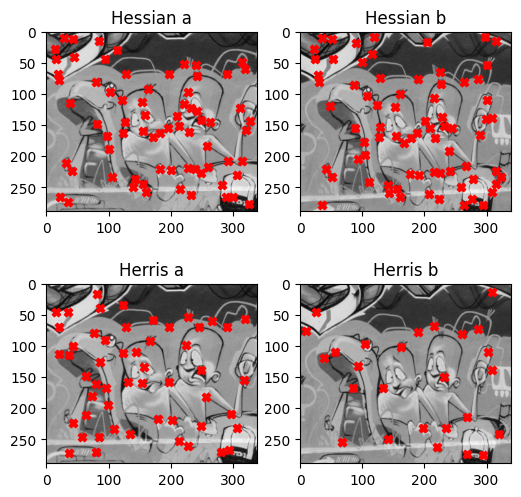

In [68]:
f = plt.figure(figsize=(6, 6))
f.add_subplot(2, 2, 1)
plt.imshow(temp, cmap="gray")
plt.scatter(points[1], points[0], c='red', marker='X')
plt.title("Hessian a")
f.add_subplot(2, 2, 2)
plt.imshow(temp2, cmap="gray")
plt.scatter(points2[1], points2[0], c='red', marker='X')
plt.title("Hessian b")
f.add_subplot(2, 2, 3)
plt.imshow(temp, cmap="gray")
plt.scatter(pointsHerris[1], pointsHerris[0], c='red', marker='X')
plt.title("Herris a")
f.add_subplot(2, 2, 4)
plt.imshow(temp2, cmap="gray")
plt.scatter(points2Herris[1], points2Herris[0], c='red', marker='X')
plt.title("Herris b")
plt.show()

In [58]:
def hellingerDistance(arr, arr2):
    return np.sqrt(0.5 * np.sum((np.sqrt(arr) - np.sqrt(arr2)) ** 2))

Using Hessian


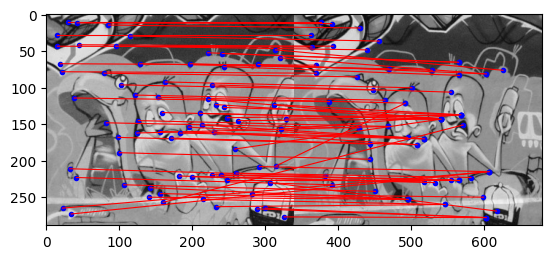

Using Herris


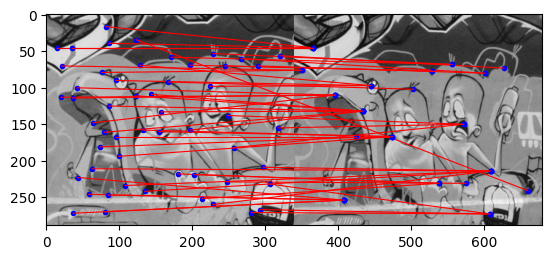

In [87]:
def find_correspondences(d1, d2):
    arr = np.zeros(len(d1), dtype=int)
    for i, d in enumerate(d1):
        j = np.argmin(np.array(list(map(lambda a : hellingerDistance(d, a), d2)))) # gets index of minimum of distances from d in list1 to every a in list2
        arr[i] = j
    return arr

descriptors = simple_descriptors(temp, points[0], points[1], n_bins=16, radius=50, sigma=2)
descriptors2 = simple_descriptors(temp2, points2[0], points2[1], n_bins=16, radius=50, sigma=2)
descriptorsHerris = simple_descriptors(temp, pointsHerris[0], pointsHerris[1], n_bins=16, radius=50, sigma=2)
descriptors2Herris = simple_descriptors(temp2, points2Herris[0], points2Herris[1], n_bins=16, radius=50, sigma=2)
indexes = find_correspondences(descriptors, descriptors2)
indexesHerris = find_correspondences(descriptorsHerris, descriptors2Herris)
# points[1]...x, points[0]...y
p = np.array([points[1], points[0]]).T
pp = np.array([points2[1][indexes], points2[0][indexes]]).T
pHerris = np.array([pointsHerris[1], pointsHerris[0]]).T
ppHerris = np.array([points2Herris[1][indexesHerris], points2Herris[0][indexesHerris]]).T
print("Using Hessian")
display_matches(temp, p, temp2, pp)
print("Using Herris")
display_matches(temp, pHerris, temp2, ppHerris)

### b

In [140]:
def find_matches(img, img2):
    Ix, Iy, Ixx, Iyy, Ixy = getDerivatives(img, 3)
    Ix2, Iy2, Ixx2, Iyy2, Ixy2 = getDerivatives(img2, 3)
    det, nnmsDet = hessian_points(Ixx, Iyy, Ixy, 0.002)
    det2, nnmsDet2 = hessian_points(Ixx2, Iyy2, Ixy2, 0.002)
    points = np.nonzero(nnmsDet)
    points2 = np.nonzero(nnmsDet2)
    descriptors = simple_descriptors(temp, points[0], points[1])
    descriptors2 = simple_descriptors(temp2, points2[0], points2[1])
    indexes = find_correspondences(descriptors, descriptors2)
    indexes2 = find_correspondences(descriptors2, descriptors)
    ijIndexes = np.array([range(0,len(indexes)), indexes]).T
    ijIndexes2 = np.array([indexes2, range(0,len(indexes2))]).T

    simmetricij = np.array([], dtype=int)
    for ij in ijIndexes:
        for ij2 in ijIndexes2:
            if (ij == ij2).all():
                simmetricij = np.append(simmetricij, ij, 0)

    simmetricij = np.reshape(simmetricij, (int(len(simmetricij)/2), 2))
    return points, points2, simmetricij

# tempImg = temp[50:200, 100:300]
# tempImg2 = temp2[50:200, 100:300]
# bPoints, bPoints2, simmetricij = find_matches(tempImg, tempImg2)
bPoints, bPoints2, simmetricij = find_matches(temp, temp2)

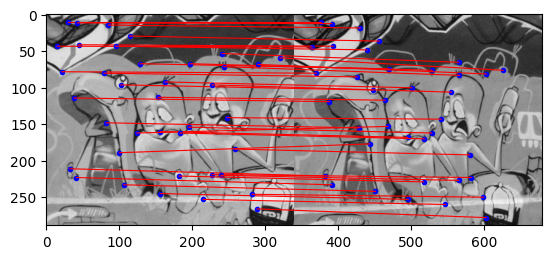

In [141]:
# points[1]...x, points[0]...y
p = np.array([bPoints[1], bPoints[0]]).T[simmetricij[:,0]]
pp = np.array([bPoints2[1], bPoints2[0]]).T[simmetricij[:,1]]
display_matches(temp, p, temp2, pp)

Question: What do you notice when visualizing the correspondences? How accurate are the matches?

Answer: Matches are pretty accurate.